In [10]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import lane_detective as ld 

1062

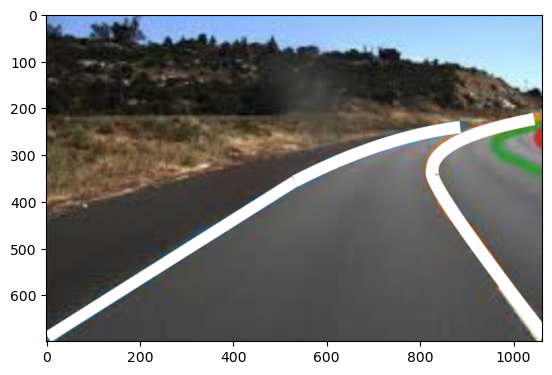

In [26]:
image_c = cv2.imread('./data/cake1.png')
plt.imshow(cv2.cvtColor(image_c, cv2.COLOR_RGB2BGR))
height, width, _ = image_c.shape
ROI = np.array([[(0,height),(width/8,height/2), (width*7/8, height/2), (width,height)]], dtype=np.int32)
image_midpoint = width / 2
width

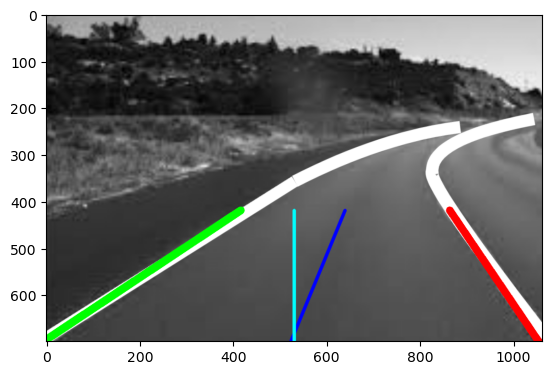

In [46]:
plt.imshow(cv2.cvtColor(ld.draw_lines_on_picture(image_c), cv2.COLOR_RGB2BGR))

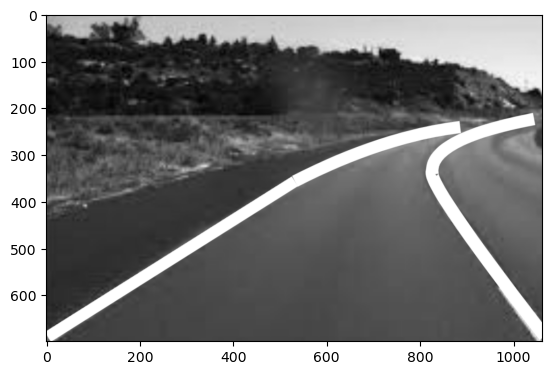

In [27]:
# Convert to grayscale
image_g = cv2.cvtColor(image_c, cv2.COLOR_RGB2GRAY)
# Convert datatype of pixels to int8
image_g = cv2.normalize(image_g, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)
plt.imshow(cv2.cvtColor(image_g, cv2.COLOR_GRAY2BGR))

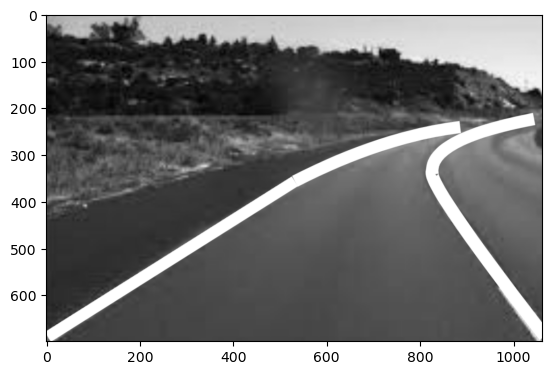

In [28]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced = clahe.apply(image_g)
plt.imshow(cv2.cvtColor(image_g, cv2.COLOR_GRAY2BGR))

np.uint8(18)

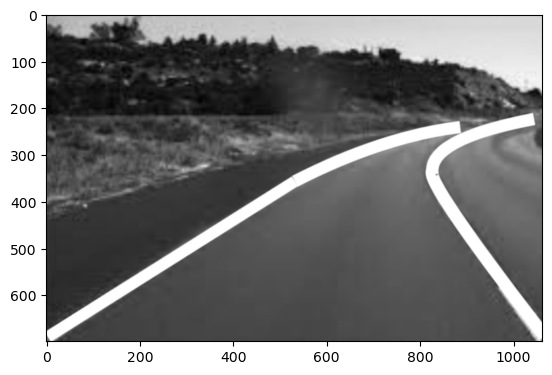

In [29]:
# Gaussian blur. More iterations to reduce noise.
image_blurred = image_g
for i in range(1):
    image_blurred = cv2.GaussianBlur(image_blurred, (3,3), 0)
plt.imshow(cv2.cvtColor(image_blurred, cv2.COLOR_GRAY2BGR))
image_blurred[110][50]

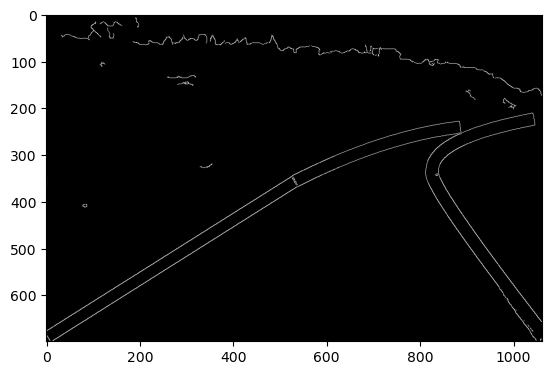

In [30]:
# Canny edge detection
threshold_low = 10
threshold_high = 200
image_canny = cv2.Canny(image_blurred, threshold_low, threshold_high)
plt.imshow(cv2.cvtColor(image_canny, cv2.COLOR_GRAY2BGR))

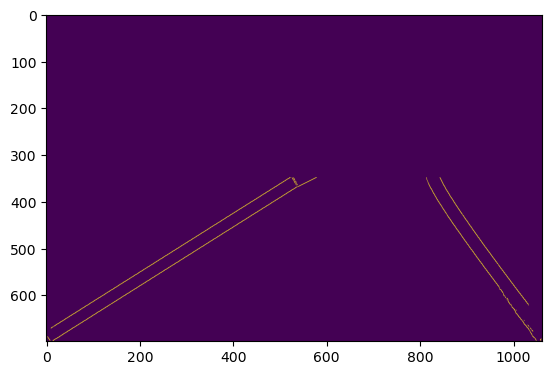

In [39]:
# MASK REGION OF INTEREST
mask = np.zeros_like(image_g)   
cv2.fillPoly(mask, ROI, 255)
image_mask = cv2.bitwise_and(image_canny, mask)
plt.imshow(image_mask)

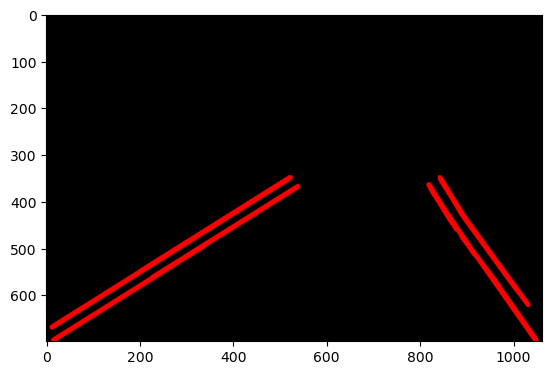

In [40]:
#DETECT LINES USING HOUGH LINE DETECTION
rho = 2             # distance resolution in pixels 
theta = np.pi/180   # angular resolution in radians 
threshold = 40      # minimum number of votes 
min_line_len = 75  # minimum number of pixels making up a line
max_line_gap = 50   # maximum gap in pixels between connectable line segments    
lines = cv2.HoughLinesP(image_mask, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
# Create an empty black image
image_hough = np.zeros((image_mask.shape[0], image_mask.shape[1], 3), dtype=np.uint8)
# Draw lines on blank canvas for visualization only    
for line in lines:
    for x1,y1,x2,y2 in line:      
        cv2.line(image_hough, (x1, y1), (x2, y2), [255, 0, 0], 10)
plt.imshow(image_hough)

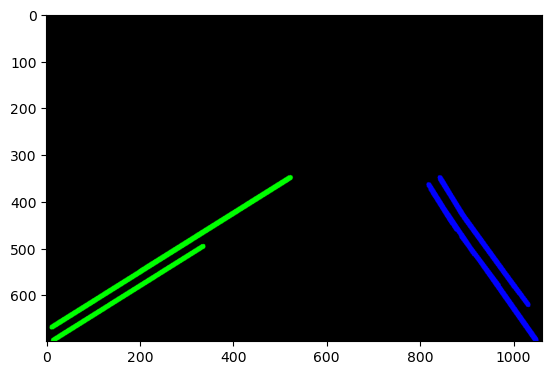

In [41]:
left_lines = []
right_lines = []

# Loop through all the lines
if lines is not None:
    for line in lines:
        for x1, y1, x2, y2 in line:           
            # Only parse lines entirely on left or right of midpoint
            if x1 < image_midpoint and x2 < image_midpoint:
                left_lines.append([x1, y1, x2, y2])
            elif x1 > image_midpoint and x2 > image_midpoint:
                right_lines.append([x1, y1, x2, y2])

# --- VISUALIZATION ---
separated_line_image = np.zeros((height, width, 3), dtype=np.uint8)

# Draw left lines in green
for x1, y1, x2, y2 in left_lines:
    cv2.line(separated_line_image, (x1, y1), (x2, y2), (0, 255, 0), 10)

# Draw right lines in blue
for x1, y1, x2, y2 in right_lines:
    cv2.line(separated_line_image, (x1, y1), (x2, y2), (0, 0, 255), 10)

plt.imshow(separated_line_image)

In [42]:
# Define function to create line of best fit from set of lines
def get_averaged_line_coords(image, lines):
    # 1. Collect all individual points from all lines
    x_points = []
    y_points = []   
    if lines is None or len(lines) == 0:
        return None
    for x1, y1, x2, y2 in lines:
        x_points.append(x1)
        x_points.append(x2)
        y_points.append(y1)
        y_points.append(y2)

    # 2. Find the line of best fit (1st-degree polynomial) returns [slope, intercept]
    line_fit = np.polyfit(y_points, x_points, 1)
    
    # 3. Generate the coordinates for our final line
    y_bottom = image.shape[0]          # At the bottom
    y_top = int(image.shape[0] * 0.6)  # 60% from the top (closer to camera and more reliable)
    
    # 4. Calculate the x values using our line model (x = m*y + b)
    # line_fit[0] is m (slope), line_fit[1] is b (intercept)
    x_bottom = int(line_fit[0] * y_bottom + line_fit[1])
    x_top = int(line_fit[0] * y_top + line_fit[1])   
    return [x_bottom, y_bottom, x_top, y_top]

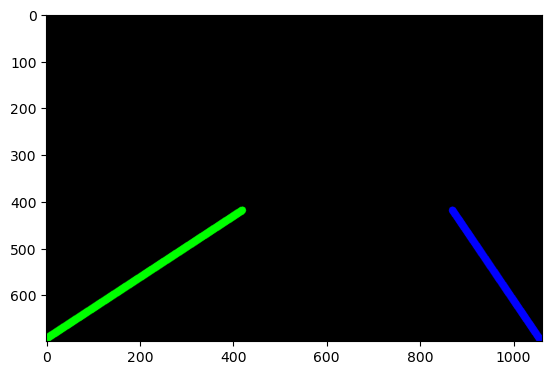

In [43]:
# Get averaged left and right lines
left_lane = get_averaged_line_coords(image_mask, left_lines)
right_lane = get_averaged_line_coords(image_mask, right_lines)

# Create a new black image to draw our final lines on
lane_image = np.zeros((height, width, 3), dtype=np.uint8)

# Draw the lines
if left_lane is not None:
    x1, y1, x2, y2 = left_lane
    cv2.line(lane_image, (x1, y1), (x2, y2), (0, 255, 0), 15) # Green
else:
    cv2.line(lane_image, (0, y1), (0, y2), (0, 255, 0), 15) # Green

if right_lane is not None:
    x1, y1, x2, y2 = right_lane
    cv2.line(lane_image, (x1, y1), (x2, y2), (0, 0, 255), 15) # Blue
else:
    cv2.line(lane_image, (width, y1), (width, y2), (0, 255, 0), 15) # Green

plt.imshow(lane_image)

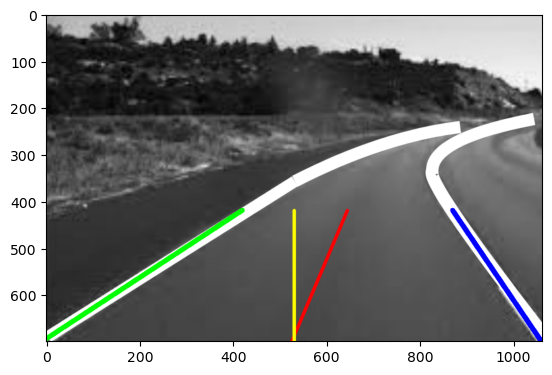

In [44]:
#get lane center at bottom
left_x_bottom = left_lane[0]
right_x_bottom = right_lane[0]
lane_center_bottom = (left_x_bottom + right_x_bottom) / 2

#get lane center at top
left_x_top = left_lane[2]
right_x_top = right_lane[2]
lane_center_top = (left_x_top + right_x_top) / 2


#calculate offsets
offset_t = image_midpoint - lane_center_top
offset_b = image_midpoint - lane_center_bottom

# Define key figures to prevent over correction/ oscillations
gain = 1             #defines the scale of adjustment
upper_tolerance = 0  #number of pixels to ignore
lower_tolerance = 0  
if abs(offset_t) < upper_tolerance:
    offset_t = 0
if abs(offset_b) < lower_tolerance:
    offset_b = 0

# Decide steering
if offset_b > 0: 
    # Current position is right of lane center, need to steer left
    steering_direction = -1
elif offset_b < 0:
    # Current position is left of lane center, need to steer right
    steering_output = 1
elif offset_b > 0:
    # camera is centered. check for trajectory
    if offset_t > 0:
        # road veers left, steer left
        steering_direction = -1
    elif offset_t < 0:
        # road veers right, steer right
        steering_direction = 1
    else:
        #On course. Do nothing
        steering_direction = 0

# If both offsets are pos or both are neg then current position and trajectory are on same side
# So then we need a big adjustment bc we're off course and going in wrong dir
# Otherwise we are off course and going in the right direction
steering_magnitude = abs(offset_b + offset_t) * gain


# Visualize
visuals = cv2.cvtColor(image_g, cv2.COLOR_GRAY2BGR)

# Draw Left (Green) and Right (Blue) lines
cv2.line(visuals, (left_lane[0], left_lane[1]), (left_lane[2], left_lane[3]), (0, 255, 0), 10)
cv2.line(visuals, (right_lane[0], right_lane[1]), (right_lane[2], right_lane[3]), (0, 0, 255), 10)

# Draw the LANE CENTER (Red)
# We can get its top coordinate the same way as the bottom

cv2.line(visuals, (int(lane_center_bottom), height), (int(lane_center_top), int(height * 0.6)), (255, 0, 0), 5, lineType=cv2.LINE_AA)

# Draw the CAR CENTER (Yellow, Dashed)
cv2.line(visuals, (int(image_midpoint), height), (int(image_midpoint), int(height * 0.6)), (255, 255, 0), 5, lineType=cv2.LINE_AA)

plt.imshow(visuals)